In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import_data
job_sequence = np.array(pd.read_excel("jobshop_final.xlsx", "sequence"))
job_amount = job_sequence.shape[0]
machine_amount = job_sequence.shape[1]
processing_time = np.array(pd.read_excel("jobshop_final.xlsx", "processing time"))
time_table = np.zeros((machine_amount, job_amount))#record processing time by x-machine, y-job
for i in range(job_amount) :
    for j in range(machine_amount) :
        time_table[job_sequence[i][j]][i] = processing_time[i][j]

print("job_sequence")
print(job_sequence)
print("proccessing time")
print(processing_time)
print("time_table")
print(time_table)

job_sequence
[[0 1 2 3]
 [0 1 3 2]
 [2 0 1 3]]
proccessing time
[[ 9  8  4  0]
 [ 5  6  3  0]
 [10  4  9  0]]
time_table
[[ 9.  5.  4.]
 [ 8.  6.  9.]
 [ 4.  0. 10.]
 [ 0.  3.  0.]]


In [167]:
#sub_funciton
def find_array_index(list_, value) :
    for index in range(len(list_)) :
        if list_[index] == value :
            return index

def find_next_machine(selected_node, job_sequence) :#find next node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) + 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def find_previous_machine(selected_node, job_sequence) : #find previous node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) - 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) :
    #check same job time 
    if find_array_index(job_sequence[selected_node[1]], selected_node[0]) != 0 :
        previous_node = find_previous_machine(selected_node, job_sequence)
        earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[selected_node[0]][selected_node[1]]
    else :
        earliest_finish_time = time_table[selected_node[0]][selected_node[1]]
     #check same machine time
    for job in range(job_amount) :
        if (selected_node[0], job) in selected_set :
            if earliest_finish_time_table[selected_node[0]][job] + time_table[selected_node[0]][selected_node[1]] > earliest_finish_time :
                earliest_finish_time = earliest_finish_time_table[selected_node[0]][job] + time_table[selected_node[0]][selected_node[1]]
    earliest_finish_time_table[selected_node[0]][selected_node[1]] = earliest_finish_time
    
def min_candidate_node(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) : 
    time = float("inf")
    machine = 0
    for node in candidate_set :
        #check same job time
        if find_array_index(job_sequence[node[1]], node[0]) != 0 :
            previous_node = find_previous_machine(node, job_sequence)
            earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[node[0]][node[1]]
        else :
            earliest_finish_time = time_table[node[0]][node[1]]
        #check same machine time
        for job in range(job_amount) :
            if (node[0], job) in selected_set :
                if earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]] > earliest_finish_time :
                    earliest_finish_time = earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]]
        if earliest_finish_time < time :
            time = earliest_finish_time
            machine = node[0]
    return machine

def find_sub_cadidate_set(i, candidate_set) :
    sub_cadidate_set = []
    for node in candidate_set :
        if node[0] == i :
             sub_cadidate_set.append(node)
    return sub_cadidate_set

def update_machine_sequence(machine_sequence, selected_node) :
    for sequence in range(job_amount) :
        if machine_sequence[selected_node[0]][sequence] == -1 :#still not ocuupy
            machine_sequence[selected_node[0]][sequence] = selected_node[1]
            break

def update_ancient_map(selected_node, selected_set, ancient_map) :
    for job in range(job_amount) :
        if (selected_node[0], job) in selected_set == False :
            ancient_map[selected_node[0]][job] == selected_node      

def find_Cmax_of_the_node(node, machine_sequence, ancient_map, job_sequence) :
    forward = 0
    backward = 0
    #find backward
    #culminative time of previous node same job
    if find_array_index(job_sequence[node[1]], node[0]) != 0 :#not a first procss in same job   
        previous_node = find_previous_machine(node, job_sequence)
        culminative_time_same_job = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_job = 0
    #culminative time of previous node same machine
    if ancient_map[node[0]][node[1]] != 0 :#not a first procss in same job 
        previous_node = ancient_map[node[0]][node[1]]
        culminative_time_same_machine = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_machine = 0
    backward = max(culminative_time_same_job, culminative_time_same_machine)
    #find forward
    for job in range(job_amount) :
        if (node[0], job) in selected_set == False :#only can connect with node without selected
            if job == node[1] :#node itself
                if sum(processing_time[processing_time[job].index(node[0]):]) > forward :
                    forward = sum(processing_time[job][processing_time[job].index(node[0]):])
            else :
                if time_table[node[0]][node[1]] + sum(processing_time[job][processing_time[job].index(node[0]):]) > forward :
                    forward = time_table[node[0]][node[1]] + sum(processing_time[processing_time[job].index(node[0]):])
    return forward + backward                      
    
                
def choose_node(sub_cadidate_set, machine_sequence, ancient_map, job_sequence, Cmax, selected_set, job_amount):
    smallist_Camx = float("inf")
    selected_node = (-1, -1)
    for node in sub_cadidate_set :
        node_Cmax = find_Cmax_of_the_node(node, machine_sequence, ancient_map, job_sequence)
        if node_Cmax < smallist_Camx :
            smallist_Camx = node_Cmax
            selected_node = node
    update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
    selected_set.append(selected_node)
    if smallist_Camx > Cmax :
        Cmax = smallist_Camx
    update_machine_sequence(machine_sequence, selected_node)
    update_ancient_map(selected_node, selected_set, ancient_map)
    return Cmax, selected_node    

def adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence) :
    selected_set.append(selected_node)
    del candidate_set[candidate_set.index(selected_node)]
    #add next process of same job
    if selected_node[0] != job_sequence[selected_node[1]][-1] :#not lsat process of job
        candidate_set.append(find_next_machine(selected_node, job_sequence))
        
def find_max(table) :
    maxmum = 0
    for i in range(len(table)) :
        if max(table[i]) > maxmum :
            maxmum = max(table[i])
    return int(maxmum)
    
def jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount) :
    color = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk']
    plt.figure(figsize=(10,5))
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            start_time = int(start_time_table[machine][job])
            finish_time = int(finish_time_table[machine][job])
            plt.plot([start_time, finish_time], [machine, machine],  linewidth = '20', color = color[job])
            plt.xticks(range(0, find_max(finish_time_table)+1, 1))
            plt.yticks([0,1,2,3])
            plt.ylabel("machine", fontsize = 16)
            plt.xlabel("timing", fontsize = 16)

[[ 0.  9. 14.]
 [ 9. 17. 23.]
 [17. 26.  0.]
 [21. 23. 32.]]
[[ 9. 14. 18.]
 [17. 23. 32.]
 [21. 26. 10.]
 [21. 26. 32.]]


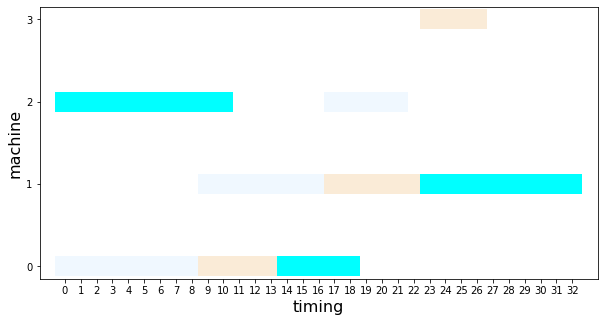

In [168]:
#parameters
machine_sequence = np.full((machine_amount, job_amount), -1)
candidate_set = [] #(machine, job)
selected_set = []
Cmax = 0
ancient_map = [[0 for i in range(job_amount)]for j in range(machine_amount)]#record sequence of same machine
earliest_finish_time_table = np.zeros((machine_amount, job_amount))#record 
#initialize
for i in range(job_amount) : #initial candidate set
    candidate_set.append((job_sequence[i][0], i))
for i in range(job_amount) : #initial current Cmax
    if sum(processing_time[i][:]) > Cmax :
            Cmax = sum(processing_time[i][:])
#main_function
for iteration in range(machine_amount*job_amount) :
    i = min_candidate_node(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
    sub_cadidate_set = find_sub_cadidate_set(i, candidate_set)
    Cmax, selected_node = choose_node(sub_cadidate_set, machine_sequence, ancient_map, job_sequence, Cmax, selected_set, job_amount)
    adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence)

start_time_table = earliest_finish_time_table - time_table
print(start_time_table)
print(earliest_finish_time_table)
jobshop_graph(earliest_finish_time_table, start_time_table, machine_amount, job_amount)

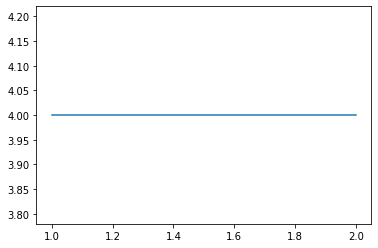

In [128]:
earliest_finish_time_table

array([[ 9., 14., 18.],
       [17., 23., 32.],
       [21., 26., 10.],
       [21., 26., 32.]])

True